In [1]:
from cvxpy import *
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [337]:
# Number of input elements (SLM/DMD pixels)
m = 5
# Number of random input masks
p = 50
# SNR (in dB)
snr = 30

## Generate a random Gaussian transmission matrix
Note that we only consider one output point. 
As each output point are treated independently, the procedure can be repeated for each output point to reconstruct a larger transmission matrix.

In [338]:
Ho = np.random.randn(m) + np.random.randn(m)*complex(0,1); 
Ho = Ho/np.sqrt(n); 
# Add noise
signal_power = np.linalg.norm(Ho)**2 / len(Ho)
noise_power = signal_power / ( 10.**(snr/10) )
Ho_noise = Ho+ np.sqrt(noise_power)*np.random.randn(Ho.shape[0])

## Generate pairs of input/ouputs

In [339]:
# input binary patterns
#X = np.random.rand(m,p)>0.5 +0j
#X = np.random.rand(m,p)+np.random.rand(m,p)*complex(0,1)
X = np.exp(complex(0,1)*np.random.rand(m,p)*2*np.pi)
Y = np.abs(Ho_noise@X)

## Semidefinite program
See the tutorial on [wavefrontshaping.net](www.wavefrontshaping.net)

In [340]:
Q = np.diag(np.abs(Y))@(np.eye(p)-np.linalg.pinv(X)@X)@np.diag(np.abs(Y))
# Variable (unkown) of the problem
U = Variable((p,p), hermitian=True)
# Objective to minimize
objective = Minimize(abs(trace(Q@U)))
# Constraints
# 1. U is positive semidefinite
constraints = [U>>0]
# 2. Elements of the diagonal are 1.
for k in range(p):
    constraints+= [U[k,k] == 1]
prob = Problem(objective,constraints)
# 3. U is Hermitian (alread set at the initialization of U)

# Run the solver
prob.solve(solver=SCS,verbose=True,eps=1e-5,max_iters = 100000)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 15147, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 100000, normalize = 1, scale = 1.00
Variables n = 3776, constraints m = 5153
Cones:	primal zero / dual free vars: 100
	soc vars: 3, soc blks: 1
	sd vars: 5050, sd blks: 1
Setup time: 1.69e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  1.25e-02 
   100| 7.22e-02  1.29e-02  8.65e-03  5.54e-01  5.72e-01  4.42e-16  3.41e-01 
   200| 1.76e-02  3.83e-03  6.95e-04  1.41e-01  1.40e-01  4.55e-

7.674082160274656e-05

## Compare the predicted output phase to the real one

The results should be good up to a global phase

Text(0.5, 1.0, 'Difference between real output phase and prediction')

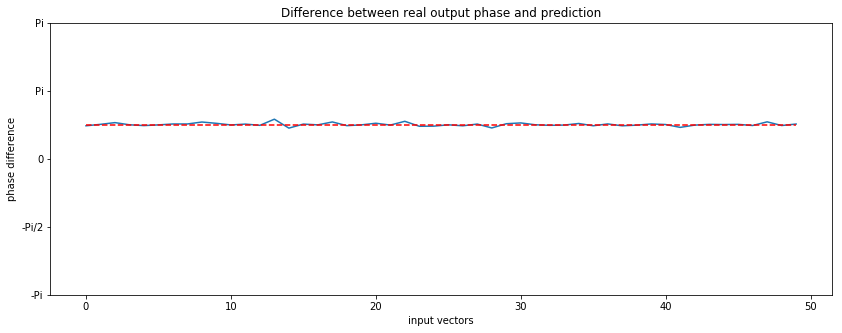

In [341]:
# Take the first eigenvector of U as the estimation of the output phase matrix
S,V = np.linalg.eig(U.value)

phase_est = -np.angle(V[:,0])
phase_real = np.angle(np.dot(Ho,X))
phase_difference = np.angle(np.exp(complex(0,1)*(phase_est-phase_real)))

phi0 = np.mean(phase_difference)
plt.figure(figsize=(14,5))
plt.plot(phase_difference)
plt.plot([phi0]*len(phase_difference),'r--')
plt.ylim([-np.pi,np.pi])
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-Pi','-Pi/2','0','Pi','Pi'])
plt.xlabel('input vectors')
plt.ylabel('phase difference')
plt.title('Difference between real output phase and prediction')

## Reconstruction of the transmission matrix

Text(0.5, 1.0, 'Imaginary part')

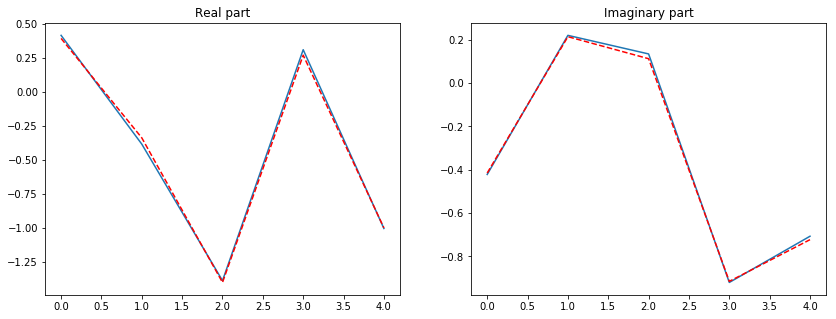

In [342]:
Y2 = Y*np.exp(complex(0,1)*(-phi0-np.angle(V[:,0])))
H_hat = Y2@np.linalg.pinv(X)
plt.figure(figsize=(14,5))
plt.title('Transmission matrix')
plt.subplot(121)
plt.plot(np.real(H_hat))
plt.plot(np.real(Ho),'r--')
plt.title('Real part')
plt.subplot(122)
plt.plot(np.imag(H_hat))
plt.plot(np.imag(Ho),'r--')
plt.title('Imaginary part')